# Negative L1 norm prior experiment

This code attempts to learn the 64D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 90713.90625
iteration 0 loss 72874.359375


iteration 5000 loss 118.25298309326172


iteration 10000 loss 48.917640686035156


iteration 15000 loss 3.070322275161743


iteration 20000 loss 1.13089120388031


iteration 25000 loss 0.6940995454788208


iteration 30000 loss 0.4653242528438568


iteration 35000 loss 0.3327987492084503


iteration 40000 loss 0.2649376094341278


iteration 45000 loss 0.2092258185148239


iteration 50000 loss 0.17292176187038422


iteration 55000 loss 0.14467555284500122


iteration 60000 loss 0.12279017269611359


iteration 65000 loss 0.10563317686319351


iteration 70000 loss 0.0934896245598793


iteration 75000 loss 0.07965175807476044


iteration 80000 loss 0.07059803605079651


iteration 85000 loss 0.25038236379623413


iteration 90000 loss 0.05632087215781212


iteration 95000 loss 0.050588998943567276


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.05438840016722679


iteration 105000 loss 0.04426785930991173


iteration 110000 loss 0.04032471776008606


iteration 115000 loss 0.036277830600738525


iteration 120000 loss 0.03336075320839882


iteration 125000 loss 0.030235478654503822


iteration 130000 loss 0.028058532625436783


iteration 135000 loss 0.025537483394145966


iteration 140000 loss 0.023649966344237328


iteration 145000 loss 0.02175423875451088


iteration 150000 loss 0.02017698995769024


iteration 155000 loss 0.018692703917622566


iteration 160000 loss 0.017480846494436264


iteration 165000 loss 0.01621335931122303


iteration 170000 loss 0.015228211879730225


iteration 175000 loss 0.014176259748637676


iteration 180000 loss 0.013393551111221313


iteration 185000 loss 0.01256715226918459


iteration 190000 loss 0.01178241427987814


iteration 195000 loss 0.011087954044342041


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.010441404767334461


iteration 205000 loss 0.010312038473784924


iteration 210000 loss 0.009629786014556885


iteration 215000 loss 0.009068966843187809


iteration 220000 loss 0.008521889336407185


iteration 225000 loss 0.007963668555021286


iteration 230000 loss 0.0075494046323001385


iteration 235000 loss 0.00710268085822463


iteration 240000 loss 0.006707887165248394


iteration 245000 loss 0.0063283261843025684


iteration 250000 loss 0.005974858999252319


iteration 255000 loss 0.00569504126906395


iteration 260000 loss 0.00537823187187314


iteration 265000 loss 0.0051282490603625774


iteration 270000 loss 0.004861315246671438


iteration 275000 loss 0.00465735886245966


iteration 280000 loss 0.004417039453983307


iteration 285000 loss 0.004227775149047375


iteration 290000 loss 0.004036663565784693


iteration 295000 loss 0.0038413573056459427


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.003680504858493805


iteration 305000 loss 0.0036047655157744884


iteration 310000 loss 0.0033400512766093016


iteration 315000 loss 0.0030890528578311205


iteration 320000 loss 0.0028582115191966295


iteration 325000 loss 0.0026449472643435


iteration 330000 loss 0.0024480395950376987


iteration 335000 loss 0.002266509924083948


iteration 340000 loss 0.0020991878118366003


iteration 345000 loss 0.0019464147044345737


iteration 350000 loss 0.001807760214433074


iteration 355000 loss 0.0016788295470178127


iteration 360000 loss 0.001559476600959897


iteration 365000 loss 0.0014544794103130698


iteration 370000 loss 0.0013642790727317333


iteration 375000 loss 0.0012824414297938347


iteration 380000 loss 0.0012050159275531769


iteration 385000 loss 0.0011343444930389524


iteration 390000 loss 0.001069803605787456


iteration 395000 loss 0.0010081575019285083


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.0009519985760562122


iteration 405000 loss 0.0009400562848895788


iteration 410000 loss 0.0009185975650325418


iteration 415000 loss 0.0008986616740003228


iteration 420000 loss 0.0008795760222710669


iteration 425000 loss 0.0008611066732555628


iteration 430000 loss 0.0008431845344603062


iteration 435000 loss 0.0008257061708718538


iteration 440000 loss 0.0008086516172625124


iteration 445000 loss 0.0007919700001366436


iteration 450000 loss 0.0007756355917081237


iteration 455000 loss 0.0007596724317409098


iteration 460000 loss 0.0007440003682859242


iteration 465000 loss 0.0007286316831596196


iteration 470000 loss 0.0007135604391805828


iteration 475000 loss 0.0006987973465584219


iteration 480000 loss 0.000684314058162272


iteration 485000 loss 0.0006701031234115362


iteration 490000 loss 0.0006562297930940986


iteration 495000 loss 0.0006425509345717728


L2 loss -- Plot

loss -3.743612766265869


loss -169.7855224609375


loss -252.72940063476562


loss -320.6732177734375


loss -372.44158935546875


loss -405.7956237792969


loss -422.253662109375


loss -427.90142822265625


loss -429.14801025390625


loss -429.3127136230469


loss -429.3246154785156


loss -429.32501220703125


loss -429.32501220703125


loss -429.3250427246094


loss -429.3250427246094


loss -429.3250427246094


loss -429.32501220703125


loss -429.32501220703125


loss -429.3250427246094


loss -429.3250427246094


loss -429.3250732421875


loss -429.3250427246094


loss -429.3250427246094


loss -429.3250427246094


loss -429.32501220703125


loss -429.32501220703125


loss -429.3250427246094


loss -429.32501220703125


loss -429.3250427246094


loss -429.3250427246094


loss -429.3250427246094


loss -429.3250427246094


loss -429.3250427246094


loss -429.32501220703125


loss -429.32501220703125


loss -429.3250427246094


loss -429.32501220703125


loss -429.32501220703125


loss -429.3250732421875


loss -429.3250427246094


final mse:  1.3994576608666875e-09
max, min: 3.155184 -2.9112146
loss -3.743612766265869


loss -169.63760375976562


loss -252.62094116210938


loss -320.8193359375


loss -372.9239196777344


loss -406.46710205078125


loss -422.7931823730469


loss -428.1986083984375


loss -429.314697265625


loss -429.4467468261719


loss -429.4548034667969


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


loss -429.45501708984375


final mse:  1.2286768269476056e-09
max, min: 3.0241203 -3.0459437


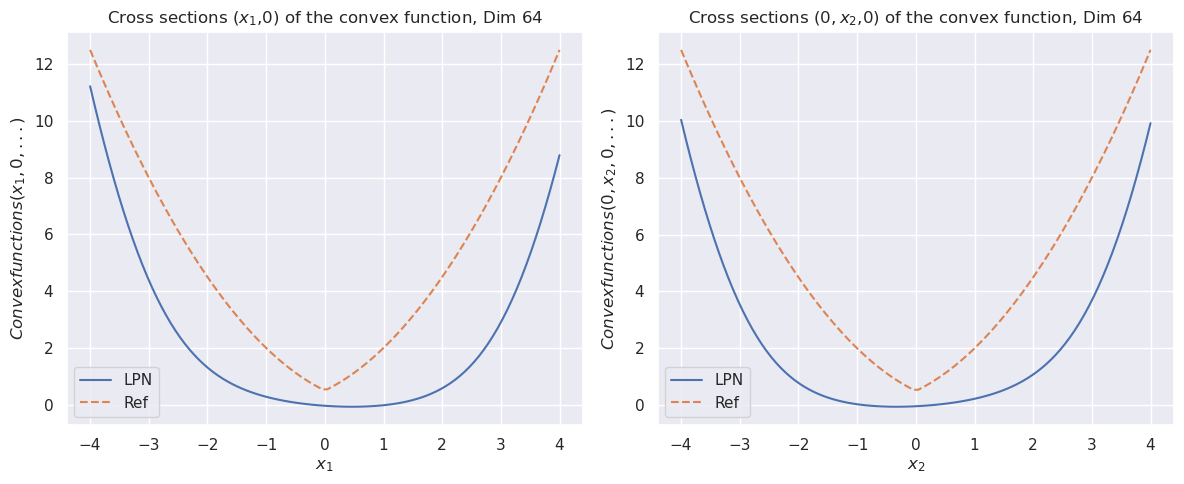

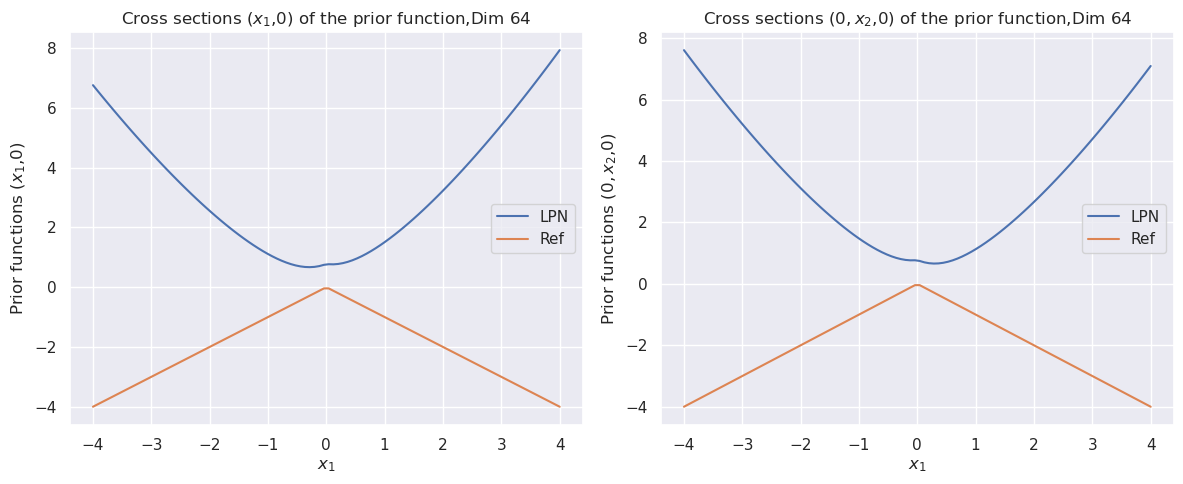

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 23439.5234375
iteration 0 loss 9130.8544921875


iteration 5000 loss 8.388768196105957


iteration 10000 loss 2.5034749507904053


iteration 15000 loss 1.1923201084136963


iteration 20000 loss 0.770931601524353


iteration 25000 loss 0.5470673441886902


iteration 30000 loss 0.3961210250854492


iteration 35000 loss 0.2971328794956207


iteration 40000 loss 0.23403559625148773


iteration 45000 loss 0.19084274768829346


iteration 50000 loss 0.15860363841056824


iteration 55000 loss 0.13668566942214966


iteration 60000 loss 0.11844396591186523


iteration 65000 loss 0.7491379976272583


iteration 70000 loss 0.09129130095243454


iteration 75000 loss 0.08289190381765366


iteration 80000 loss 0.07449820637702942


iteration 85000 loss 0.0679033175110817


iteration 90000 loss 0.06213344633579254


iteration 95000 loss 0.0575764998793602


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.05325835943222046


iteration 105000 loss 0.05162188410758972


iteration 110000 loss 0.047887835651636124


iteration 115000 loss 0.04452085494995117


iteration 120000 loss 0.04184515401721001


iteration 125000 loss 0.03920501470565796


iteration 130000 loss 0.03684123232960701


iteration 135000 loss 0.034916430711746216


iteration 140000 loss 0.032860055565834045


iteration 145000 loss 0.031177503988146782


iteration 150000 loss 0.029586993157863617


iteration 155000 loss 0.028206421062350273


iteration 160000 loss 0.026769079267978668


iteration 165000 loss 0.025476893410086632


iteration 170000 loss 0.02429541014134884


iteration 175000 loss 0.023245085030794144


iteration 180000 loss 0.022172240540385246


iteration 185000 loss 0.02119607664644718


iteration 190000 loss 0.020453570410609245


iteration 195000 loss 0.021848607808351517


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.018869774416089058


iteration 205000 loss 0.01842767372727394


iteration 210000 loss 0.01745828427374363


iteration 215000 loss 0.016611311584711075


iteration 220000 loss 0.01581001468002796


iteration 225000 loss 0.01506311260163784


iteration 230000 loss 0.0143992705270648


iteration 235000 loss 0.013796204701066017


iteration 240000 loss 0.013203765265643597


iteration 245000 loss 0.01265635620802641


iteration 250000 loss 0.012148532085120678


iteration 255000 loss 0.011689948849380016


iteration 260000 loss 0.011251349933445454


iteration 265000 loss 0.01084024179726839


iteration 270000 loss 0.010475855320692062


iteration 275000 loss 0.010120588354766369


iteration 280000 loss 0.009788994677364826


iteration 285000 loss 0.009464852511882782


iteration 290000 loss 0.009169849567115307


iteration 295000 loss 0.00888156145811081


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.008618098683655262


iteration 305000 loss 0.00854485109448433


iteration 310000 loss 0.008326363749802113


iteration 315000 loss 0.008109771646559238


iteration 320000 loss 0.007902001030743122


iteration 325000 loss 0.007701482158154249


iteration 330000 loss 0.007507250644266605


iteration 335000 loss 0.0073188901878893375


iteration 340000 loss 0.007136201951652765


iteration 345000 loss 0.006958733778446913


iteration 350000 loss 0.0067865378223359585


iteration 355000 loss 0.0066193267703056335


iteration 360000 loss 0.006456565111875534


iteration 365000 loss 0.006298215128481388


iteration 370000 loss 0.006144051905721426


iteration 375000 loss 0.00599380349740386


iteration 380000 loss 0.00584753043949604


iteration 385000 loss 0.0057050613686442375


iteration 390000 loss 0.005566189996898174


iteration 395000 loss 0.005430812016129494


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.005298595875501633


iteration 405000 loss 0.005280899815261364


iteration 410000 loss 0.005260537378489971


iteration 415000 loss 0.005240751430392265


iteration 420000 loss 0.00522131472826004


iteration 425000 loss 0.005202167201787233


iteration 430000 loss 0.005183203611522913


iteration 435000 loss 0.005164437927305698


iteration 440000 loss 0.00514587014913559


iteration 445000 loss 0.0051274048164486885


iteration 450000 loss 0.005109122022986412


iteration 455000 loss 0.005090955179184675


iteration 460000 loss 0.005072908941656351


iteration 465000 loss 0.0050549558363854885


iteration 470000 loss 0.005037130322307348


iteration 475000 loss 0.005019424948841333


iteration 480000 loss 0.005001794546842575


iteration 485000 loss 0.004984264727681875


iteration 490000 loss 0.00496682059019804


iteration 495000 loss 0.004949508234858513


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


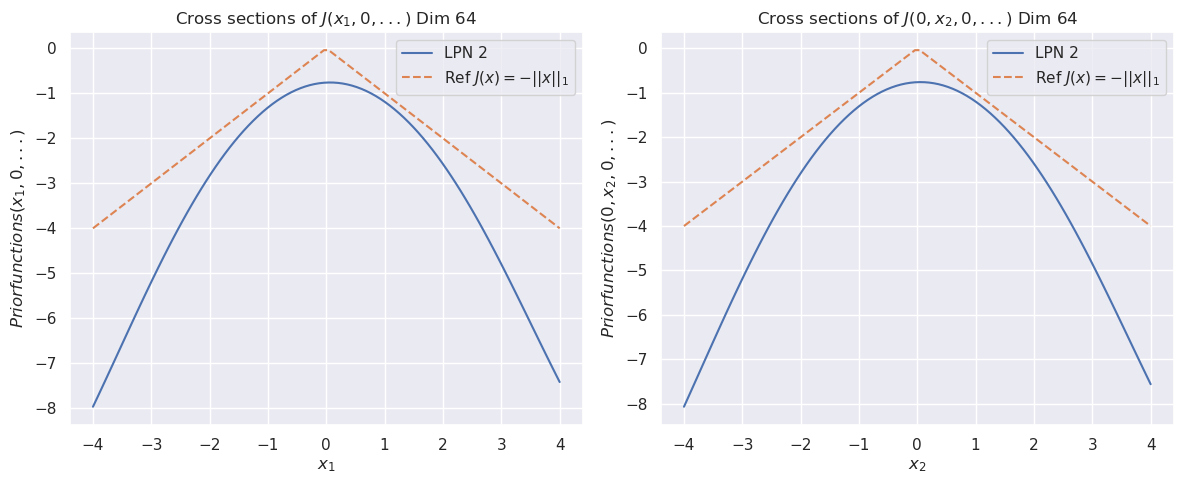

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)